# Workshop Topic Modeling
## by Cornelius Puschmann, Tatjana Scheffler, Damian Trilling

IC2S2 Conference, 11-13 July, 2017

Tutorial Day, 10 July, 2017

### Workshop overview
2. Algorithms/formal background (Tatjana)
3. From text to features: preprocessing, tokens, n-grams (Damian)
4. Heuristics for the removal of stopwords (Cornelius)
5. Tuning of the topic number for optimal model fit (Cornelius)
6. Evaluating and comparing different models (Tatjana/Damian)
7. Visualizing and interactively exploring topic models (Damian/Cornelius)
8. What’s the next step in the pipeline? Using the results of a topic model (Damian)
9. Alternatives to LDA: Dynamic topic models / CTM / L-LDA (Tatjana)


# Preparation
We assume that you run Python 3 and have NLTK (Bird, Loper, & Klein, 2009) installed. If you use Anaconda, you have it anyway. Otherwise, use 
```
pip install nltk
```
or 
```
sudo pip install nltk
```
(or possibly pip3) in your terminal to install it.


We also assume you have `gensim` and `pyldavis` installed, if not, do so as well using pip.

Furthermore, we have to download some data for some specific NLTK modules. Download them by executing the following cell (you only have to do this once):

Bird, S., Loper, E., & Klein, E. (2009). *Natural language processing with Python*. Sebastopol, CA: O'Reilly.

In [1]:
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('maxent_treebank_pos_tagger')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Let's get started!

## Import modules
Before we start, let's import some modules that we need today. It is good practice to do so at the beginning of a script, so we'll do it right now and not later when we need them. The benefit is that you immediately see if something goes wrong (for instance, because the module is not installed).

In [2]:
import csv
import re
from glob import glob
from string import punctuation
import random
random.seed("ic2s2colgne")
from nltk.sentiment import vader
from nltk.corpus import stopwords
import nltk
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Download the data
We will use a dataset by Schumacher et al. (2016). From the abstract:
> This paper presents EUSpeech, a new dataset of 18,403 speeches from EU leaders (i.e., heads of government in 10 member states, EU commissioners, party leaders in the European Parliament, and ECB and IMF leaders) from 2007 to 2015. These speeches vary in sentiment, topics and ideology, allowing for fine-grained, over-time comparison of representation in the EU. The member states we included are Czech Republic, France, Germany, Greece, Netherlands, Italy, Spain, United Kingdom, Poland and Portugal.

Schumacher, G, Schoonvelde, M., Dahiya, T., Traber, D, & de Vries, E. (2016): *EUSpeech: a New Dataset of EU Elite Speeches*. [doi:10.7910/DVN/XPCVEI](http://dx.doi.org/10.7910/DVN/XPCVEI)

Download and unpack the following file:
```
speeches_csv.tar.gz
```

In the .tar.gz file, you find a .zip file. Extract the whole folder to your home directory.
See below a screenshot of how this looks like in Lubuntu (double-click on "speeches_csv.zip" in the left window, then the right window will open. Click on "Extract")

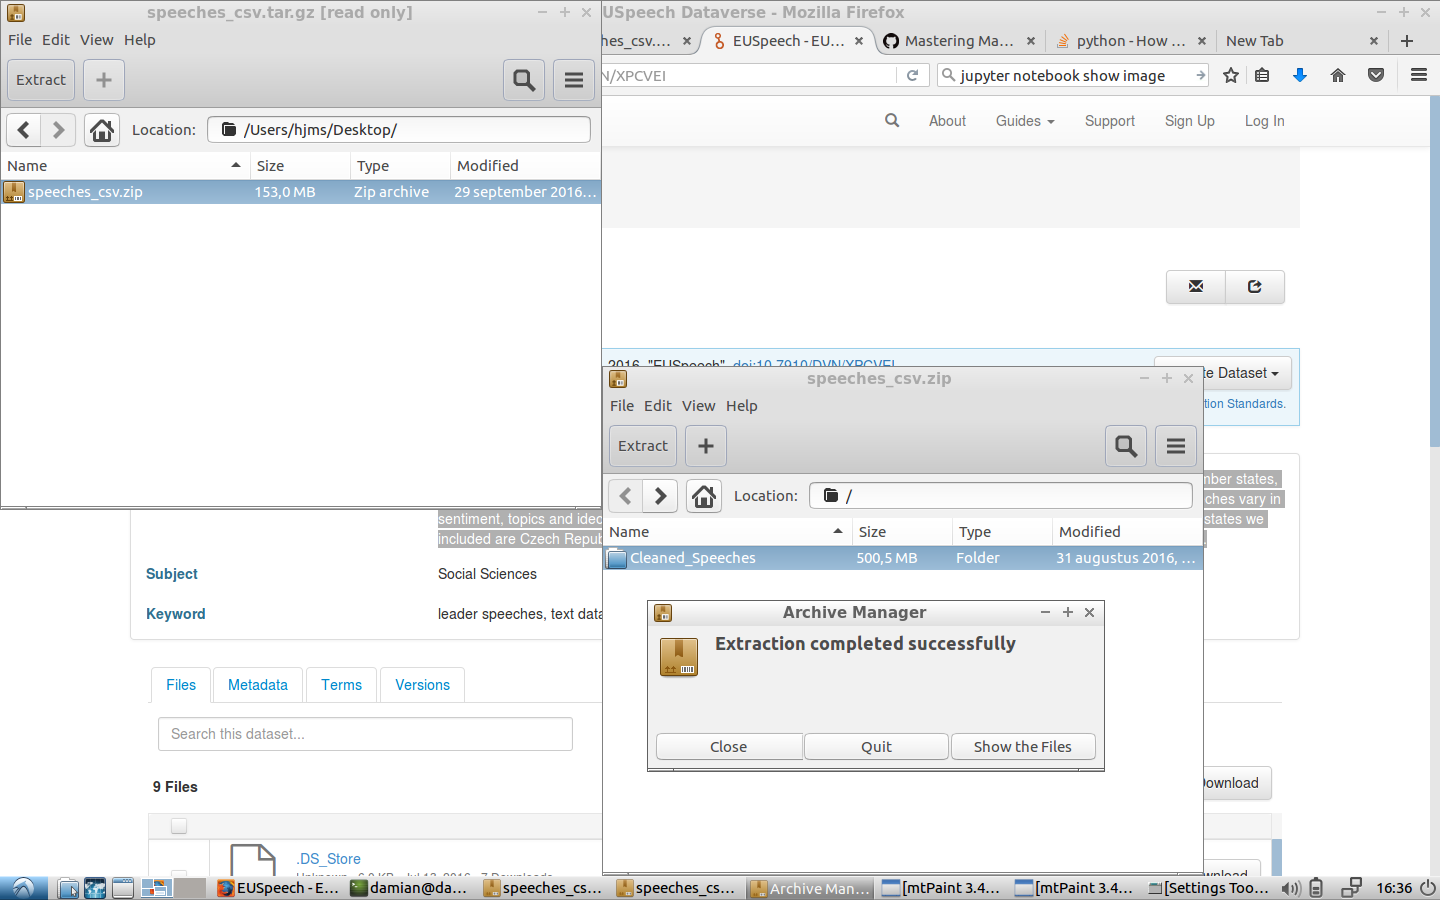

In [3]:
from IPython.display import Image
Image("https://github.com/damian0604/bdaca/raw/master/ipynb/euspeech_download.png")

Let's have a look at the files we downloaded.

In [4]:
%ls ~/Cleaned_Speeches/

Speeches_ALDE_Cleaned.csv*       Speeches_GR_Cleaned.csv*
Speeches_CZ_Cleaned.csv*         Speeches_IMF_Cleaned.csv*
Speeches_DE_Cleaned.csv*         Speeches_IT_Cleaned.csv*
Speeches_ECB_Cleaned.csv*        Speeches_NL_Cleaned.csv*
Speeches_EC_Cleaned.csv*         Speeches_PL_Cleaned.csv*
Speeches_ECR_Cleaned.csv*        Speeches_PO_Cleaned.csv*
Speeches_EP_Cleaned.csv*         Speeches_SP_Cleaned.csv*
Speeches_EUCouncil_Cleaned.csv*  Speeches_UK_Cleaned.csv*
Speeches_FR_Cleaned.csv*         Translated/


## Let's start!
Let's retrieve a list of all speeches from one of the files. Of course, we could also loop over all the files...

In [5]:
#filelist = glob('Cleaned_Speeches/Speeches_*_Cleaned.csv')
# instead of all speeches, to speed up things, we are focusing on speeches from the Netherlands only
filelist = glob('Cleaned_Speeches/Speeches_NL_Cleaned.csv')
print(filelist)
speeches=[]
for fn in filelist:
    with open(fn) as fi:
        reader=csv.reader(fi)
        for row in reader:
            if row[7]=='en':   # only include english-language speches; we might as well choose 'nl' or 'fr'
                speeches.append(row[5])

['Cleaned_Speeches/Speeches_NL_Cleaned.csv']


In [6]:
len(speeches)

132

In [7]:
# To speed things up, we could also use 100 speeches only. 
# speeches = random.sample(speeches,100)
# len(speeches)

In [8]:
speeches[0][:500]

"<p>Ladies and gentlemen,</p><p>It is an honour to be here today to introduce the theme of 'recession and recovery'. If you will permit, I would like to suggest that this afternoon we focus more on recovery than on recession. I think we know enough about the recession side of the story.</p><p>It started with the fall of Lehman Brothers on 15 September 2008. I happened to be here, at the Blouin Creative Leadership Summit, only ten days later. Everyone was talking about the collapse of Lehman. They"

# 2. From text to features: preprocessing, tokens, n-grams (Damian)
## General approach

From a machine-learning perspective, one could argue that all information in a text might be useful information. However, we are interested in getting *interpretable* topics, so even if for instance the use of specific HTML tags would help us distinguising between some documents, we want to get rid of them. More in general, we start by cleaning up a bit to get only 'real' text.

### Some typical clean-up steps:

In [9]:
speeches=[speech.replace('<p>',' ').replace('</p>',' ') for speech in speeches]   #remove HTML tags
speeches=["".join([l for l in speech if l not in punctuation]) for speech in speeches]  #remove punctuation
speeches=[speech.lower() for speech in speeches]  # convert to lower case
speeches=[" ".join(speech.split()) for speech in speeches]   # remove double spaces by splitting the strings into words and joining these words again

Let's look at the first speech to check everything's fine.

In [10]:
speeches[0][:500]

'ladies and gentlemen it is an honour to be here today to introduce the theme of recession and recovery if you will permit i would like to suggest that this afternoon we focus more on recovery than on recession i think we know enough about the recession side of the story it started with the fall of lehman brothers on 15 september 2008 i happened to be here at the blouin creative leadership summit only ten days later everyone was talking about the collapse of lehman they were shocked and alarmed b'

However, as with other unsupervised machine learning techniques, we are not really interesting a long string of text. We rather want to have each document being represented by a set of *features*. To this end, `gensim` has a finciton `doc2bow` that converts a list of words (tokens) to `(token_id, token_count)` tuples. 

In [11]:
ldainput = [speech.split() for speech in speeches]           # convert all strings to list of words
id2word = corpora.Dictionary(ldainput)                       # assign a token_id to each word
ldacorpus = [id2word.doc2bow(doc) for doc in ldainput]       # represent each speech by (token_id, token_count) tuples

Let's just run a simple LDA on this to check out whether it works. We specify the corpus (in wich each document is represented by a `(token_id, token_count)` tuple), the table to translate the token_id's back to words, and the number of topics we want. 

In [12]:
myfirstlda = models.LdaModel(ldacorpus, id2word=id2word, num_topics=10)
myfirstlda.print_topics()
                            

[(0,
  '0.062*the + 0.025*and + 0.019*of + 0.018*we + 0.017*to + 0.017*in + 0.013*a + 0.011*that + 0.010*are + 0.009*for'),
 (1,
  '0.062*the + 0.051*and + 0.029*of + 0.022*to + 0.020*in + 0.018*a + 0.015*that + 0.014*is + 0.012*we + 0.010*for'),
 (2,
  '0.053*the + 0.036*and + 0.026*in + 0.021*of + 0.016*a + 0.013*to + 0.012*are + 0.011*we + 0.010*that + 0.009*for'),
 (3,
  '0.059*the + 0.033*and + 0.033*to + 0.027*of + 0.021*in + 0.015*we + 0.015*a + 0.012*that + 0.011*is + 0.010*our'),
 (4,
  '0.053*the + 0.031*and + 0.028*to + 0.026*in + 0.021*of + 0.017*we + 0.017*a + 0.016*that + 0.010*is + 0.010*are'),
 (5,
  '0.049*the + 0.046*and + 0.026*to + 0.025*in + 0.023*of + 0.013*that + 0.013*a + 0.012*we + 0.009*for + 0.008*are'),
 (6,
  '0.038*the + 0.033*and + 0.023*in + 0.022*of + 0.021*to + 0.016*a + 0.012*that + 0.011*is + 0.011*we + 0.009*for'),
 (7,
  '0.051*the + 0.036*and + 0.027*to + 0.025*of + 0.023*in + 0.017*that + 0.014*we + 0.014*a + 0.012*for + 0.012*is'),
 (8,
  '0.065

## Stopwords
We immediately see that the result of our first LDA doesn't make much sense: We see only stopwords. 


### Explicit stopword removal
The most straightforward approach is to use a pre-existing list with stopwords, possibly with the addition of some own, case-specific words. We then split up each speech in words, and only if a word is not on the stopwordlist, we keep it and join it with the previous and next word using a space.

In [13]:
mystopwords = set(stopwords.words('english')) # use default NLTK stopword list; alternatively:
# mystopwords = set(open('mystopwordfile.txt').readlines())  #read stopword list from a textfile with one stopword per line

speechesclean = [" ".join([w for w in speech.split() if w not in mystopwords]) for speech in speeches]

In [14]:
speechesclean[0][:500]

'ladies gentlemen honour today introduce theme recession recovery permit would like suggest afternoon focus recovery recession think know enough recession side story started fall lehman brothers 15 september 2008 happened blouin creative leadership summit ten days later everyone talking collapse lehman shocked alarmed even could hardly imagine impact would dramatic historic know event triggered global financial economic crisis governments forced give cash injections running billions prevent econo'

Let's check whether this looks better:

In [15]:
ldainputclean = [speech.split() for speech in speechesclean]      # speechesclean instead of speeches
id2wordclean = corpora.Dictionary(ldainput)                       
ldacorpusclean = [id2word.doc2bow(doc) for doc in ldainputclean]  
myfirstldaclean = models.LdaModel(ldacorpusclean, id2word=id2wordclean, num_topics=10)
myfirstldaclean.print_topics(num_words=5)

[(0,
  '0.009*dutch + 0.009*netherlands + 0.007*like + 0.006*world + 0.005*also'),
 (1,
  '0.009*world + 0.007*netherlands + 0.006*dutch + 0.006*one + 0.006*people'),
 (2,
  '0.015*netherlands + 0.008*also + 0.007*dutch + 0.007*countries + 0.006*international'),
 (3,
  '0.011*netherlands + 0.005*world + 0.005*also + 0.004*people + 0.004*dutch'),
 (4,
  '0.007*netherlands + 0.007*dutch + 0.007*us + 0.005*today + 0.005*people'),
 (5, '0.019*netherlands + 0.009*dutch + 0.006*also + 0.006*world + 0.005*us'),
 (6,
  '0.011*netherlands + 0.008*dutch + 0.006*us + 0.006*countries + 0.006*also'),
 (7,
  '0.009*netherlands + 0.007*dutch + 0.007*world + 0.006*us + 0.006*people'),
 (8,
  '0.010*netherlands + 0.006*people + 0.006*also + 0.006*countries + 0.006*one'),
 (9, '0.010*dutch + 0.010*netherlands + 0.007*like + 0.006*also + 0.005*one')]

### TF-IDF scores instead of word counts as features
Explicitly removing stopwords is a common practice and often very useful. We shouldn't forget, though, that there are some problematic aspects to it as well
- It is kind of arbitrary what is on the stopword list and what now
- Depending on the research question one is interested in, it might differ what words are 'meaningful'
- Although the list is meant to consist of words that occur with a high frequency in all texts, it is not based on actual frequencies in the corpus but set a priori.
A different approach would therefore be to simply use (a) the frequency of each word in the corpus and (b) the number of documents in which the document occurs. 
In other words: If we use tf-idf scores (term frequency weighed by the inverse document frequncy) instead of raw word counts as featues, the stopwords should disappear automatically:

In [16]:
tfidfcorpus = models.TfidfModel(ldacorpus)
mytfidflda = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=10)
mytfidflda.print_topics(num_words=5)

[(0,
  '0.002*indonesia + 0.001*palestinian + 0.001*vietnam + 0.001*russian + 0.001*nuclear'),
 (1,
  '0.002*internet + 0.001*mekong + 0.001*delta + 0.001*vietnam + 0.001*climate'),
 (2,
  '0.001*indonesia + 0.001*victims + 0.001*tragedy + 0.001*indonesian + 0.001*mh17'),
 (3,
  '0.001*canadian + 0.001*texas + 0.001*canadians + 0.001*vietnam + 0.001*korean'),
 (4,
  '0.001*south + 0.001*africa + 0.001*sanitation + 0.001*poland + 0.001*she'),
 (5,
  '0.001*texas + 0.001*turkey + 0.001*fighters + 0.001*terrorist + 0.001*cyber'),
 (6,
  '0.001*texas + 0.001*vietnam + 0.001*malaysia + 0.001*american + 0.001*sustainable'),
 (7,
  '0.001*nuclear + 0.001*malaysia + 0.001*summit + 0.001*missions + 0.001*un'),
 (8,
  '0.001*yesdelft + 0.001*palestinian + 0.001*lula + 0.001*women + 0.001*recovery'),
 (9,
  '0.001*missions + 0.001*nuclear + 0.001*indian + 0.001*climate + 0.001*christian')]

## Filtering extremes
Just as we don't want to include words that are all over the place and do little to distinguish documents, we also do not want to include words that virtually never occur. If among millions of words, a word occurs exactly one time, it might be simply a spelling mistake. But even if it is not, it does not help us to infer topics across documents. 

Also in purely pragmatic terms, it makes sense to remove unneccessary features to speed up the analysis process.


In [17]:
ldainput = [speech.split() for speech in speeches]           
id2word = corpora.Dictionary(ldainput)                       

id2word.filter_extremes(no_below=5, no_above=0.5)   # do not consider all words that occur in less than n=5 documents
                                                    # or in more than 50% of all documents.

ldacorpus = [id2word.doc2bow(doc) for doc in ldainput]
tfidfcorpus = models.TfidfModel(ldacorpus)
mytfidflda = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=10)
mytfidflda.print_topics(num_words=5)

[(0,
  '0.004*indonesia + 0.003*internet + 0.002*production + 0.002*australia + 0.002*head'),
 (1,
  '0.003*indonesia + 0.003*freedoms + 0.003*rights + 0.002*she + 0.002*indonesian'),
 (2,
  '0.004*india + 0.002*cyber + 0.002*american + 0.002*malaysia + 0.002*freedom'),
 (3,
  '0.005*vietnam + 0.002*recovery + 0.002*victims + 0.002*tragedy + 0.002*fifteen'),
 (4,
  '0.003*internet + 0.002*flanders + 0.002*trade + 0.002*that’s + 0.002*cyber'),
 (5,
  '0.004*indonesia + 0.003*indonesian + 0.003*chinas + 0.002*forum + 0.002*it’s'),
 (6, '0.002*terrorist + 0.002*victims + 0.002*york + 0.002*she + 0.002*mh17'),
 (7, '0.003*japan + 0.002*climate + 0.002*china + 0.002*nuclear + 0.002*war'),
 (8, '0.003*missions + 0.003*africa + 0.003*water + 0.002*un + 0.002*delta'),
 (9, '0.005*nuclear + 0.003*russia + 0.002*material + 0.002*– + 0.002*men')]

## Other preprocessing ideas

### Stemming
Stemming can be useful to avoid that 'economics', 'economic', and 'economy' are seen as different concepts by the topic model. In practice, however, standard stemming algorithms are far from perfect:

In [18]:
stemmer = nltk.stem.snowball.EnglishStemmer()
speechesstemmed = [" ".join([stemmer.stem(word) for word in speech.split()]) for speech in speeches]
speechesstemmed[0][:500]

'ladi and gentlemen it is an honour to be here today to introduc the theme of recess and recoveri if you will permit i would like to suggest that this afternoon we focus more on recoveri than on recess i think we know enough about the recess side of the stori it start with the fall of lehman brother on 15 septemb 2008 i happen to be here at the blouin creativ leadership summit onli ten day later everyon was talk about the collaps of lehman they were shock and alarm but even then we could hard ima'

### Parsing and retaining only nouns and adjectives
Depending on the specific use case at hand, one might discover that some parts of speech (POS) are more informative than others. We could, for instance, create a topic model based on only the nouns and adjectives in a text, disregarding everything else. 
Look at the NLTK documentation to find out what each code means (e.g., 'NN' is 'noun') 

In [19]:
speechesnounsadj=[]
for speech in speeches:
    tokens = nltk.word_tokenize(speech)
    tagged = nltk.pos_tag(tokens)
    cleanspeech = ""
    for element in tagged:
        if element[1] in ('NN','NNP','JJ'):
            cleanspeech=cleanspeech+element[0]+" "
    speechesnounsadj.append(cleanspeech)

### Using ngrams as features
Topic models follow a bag-of-words approach, meaning they do not take word order into account. However, sometimes we want to be able to do so to a limited extend: The "white house" is something else than a "house with a white wall", even though both strings contain the words 'white' and 'house'. We can do so by joining adjacent words together in so-called bigrams (or trigrams, if we take three words).

In [20]:
speechesbigrams = [["_".join(tup) for tup in nltk.ngrams(speech.split(),2)] for speech in speechesclean]

In [21]:
# maybe we want both unigrams and bigrams in the feature set?
assert len(speechesclean)==len(speechesbigrams)
speechesuniandbigrams = []
for a,b in zip([speech.split() for speech in speechesclean],speechesbigrams):
    speechesuniandbigrams.append(a + b)

In [22]:
len(speechesuniandbigrams[6]),len(speechesbigrams[6]),len(speechesclean[6].split())

(613, 306, 307)

In [23]:
id2word = corpora.Dictionary(speechesuniandbigrams)                       
id2word.filter_extremes(no_below=5, no_above=0.5)
ldacorpus = [id2word.doc2bow(doc) for doc in speechesuniandbigrams]
tfidfcorpus = models.TfidfModel(ldacorpus)
mytfidflda = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=10)
mytfidflda.print_topics(num_words=5)

[(0, '0.002*european + 0.002*vietnam + 0.001*victims + 0.001*– + 0.001*it’s'),
 (1,
  '0.002*indonesia + 0.002*freedom + 0.002*japan + 0.001*space + 0.001*yesterday'),
 (2, '0.003*women + 0.002*girls + 0.002*nuclear + 0.002*south + 0.002*school'),
 (3,
  '0.003*indonesian + 0.003*nuclear + 0.002*american + 0.002*security + 0.002*indonesia'),
 (4,
  '0.002*georgia + 0.002*internet + 0.002*russia + 0.002*atlanta + 0.002*cyber'),
 (5,
  '0.002*sustainable + 0.002*energy + 0.002*china + 0.002*girls + 0.002*delta'),
 (6,
  '0.002*investment + 0.001*ministerial + 0.001*new_york + 0.001*york + 0.001*council'),
 (7,
  '0.002*india + 0.002*vietnam + 0.002*terrorist + 0.001*russia + 0.001*threat'),
 (8,
  '0.002*internet + 0.002*tragedy + 0.002*mh17 + 0.002*victims + 0.002*vietnam'),
 (9,
  '0.003*indonesia + 0.003*malaysia + 0.002*chinas + 0.002*freedom + 0.002*nuclear')]

## Summing up
While there are different ways to achieve the desired results and different modules to help you with it (writing from scratch, NLTK, but also gensim.utils), these are some steps to consider when transforming texts to feature sets for topic modeling (recall that not all of them might be neccessary of even diserable, depending on the use case):

- transforming to lowercase
- removing stopwords
- stemming
- POS-tagging (and removing unwanted elements)
- filtering extremely common and extremely uncommon words
- ngrams and/or unigrams as features?
- raw frequencies or TF-IDF scores as features?



# 5. Evaluating and comparing different models (Tatjana/Damian)
(ICH WARTE HIER MAL AUF DEINEN INPUT, TATJANA, DU WEISST DA BESSER BESCHEID ALS ICH DENKE ICH...)

EIN PAAR FRAGMENTE HIER DRUNTER:


## Log perplexity
To print more info while estimating a topic model, just activate logging before you estimate the models:

In [24]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Topic coherence
We can calculate the Umass topic coherence for each topic. See Mimno, Wallach, Talley, Leenders, McCallum: Optimizing Semantic Coherence in Topic Models, CEMNLP 2011

In [33]:
mytfidflda.top_topics(ldacorpus)

/usr/local/lib/python3.4/dist-packages/gensim/models/ldamodel.py:874: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  for l in top_words[:m_index - 1]:
/usr/local/lib/python3.4/dist-packages/gensim/models/ldamodel.py:874: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  for l in top_words[:m_index - 1]:
/usr/local/lib/python3.4/dist-packages/gensim/models/ldamodel.py:874: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  for l in top_words[:m_index - 1]:
/usr/local/lib/python3.4/dist-packages/gensim/models/ldamodel.py:874: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  for l in top_words[:m_index - 1]:
/usr/local/lib/python3.4/dist-packages/gensim/models/ldamodel.py:874: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error 

[([(0.0018867527114849792, 'india'),
   (0.0017339853097800583, 'vietnam'),
   (0.0015332506134609258, 'terrorist'),
   (0.0013866731715781472, 'russia'),
   (0.0012656655512214038, 'threat'),
   (0.0011397085021555423, 'sanctions'),
   (0.0011048870562855929, 'climate'),
   (0.0011005255557385366, 'foreign'),
   (0.0011003414015972805, 'act'),
   (0.0010603497188152592, 'business_people'),
   (0.0010305950590667114, 'water'),
   (0.0010050012736482301, 'bilateral'),
   (0.0009758932067573309, 'states'),
   (0.0009635096722154969, '–'),
   (0.00094698077850846249, 'level'),
   (0.00094474812569479932, 'subjects'),
   (0.00094417826925250338, 'partnership'),
   (0.00093200509319558923, 'security'),
   (0.00092961467942310994, 'underlines_importance'),
   (0.00091643753390319345, 'goals')],
  -210.74602912058177),
 ([(0.0021858705870893757, 'georgia'),
   (0.0021843231491238489, 'internet'),
   (0.0020768676898371349, 'russia'),
   (0.0019627284554389881, 'atlanta'),
   (0.00160801117418

# 6. Visualizing and interactively exploring topic models (Damian/Cornelius)
A great tool for interactively exploring topicmodels is pyLDAvis.
pyLDAvis can estimate its own topic models, but it als has a nice function called `gensim.prepare`, which you can use to visualize the model you already estimated with gensim.

In [26]:
vis_data = pyLDAvis.gensim.prepare(mytfidflda,ldacorpus,id2word)
pyLDAvis.display(vis_data)

# 7. What’s the next step in the pipeline? Using the results of a topic model (Damian)

Until know, we have mainly considered the interpretation of the topics themselves. While it can indeed be interesting to use topic models to summarize and interpret large corpora, this is usually not where social scientists stop: We want to relate the topics back to documents to say something about which topics occur in which documents.

## Saving topic scores to a file
Somewhat similar to factor analysis and principal component analysis, where one can also store factor scores that indicate how high a specific case scores on each of the factors that were identified, for each document, we can estimate a score for each of the topics we identified.

To do so, we can simply call the `.inference()` method on the model we estimated. 

In [27]:
scoresperdoc=mytfidflda.inference(ldacorpus)

In [28]:
len(scoresperdoc[0])

132

We could do a lot of different stuff with the resulting matrix, in which each row represents one of the documents and each row consists of one score for each topic.
For example, we just could create a tab-separated file:

In [29]:
with open("topicscores.tsv","w",encoding="utf-8") as fo:
    for row in scoresperdoc[0]:
       fo.write("\t".join(["{:0.3f}".format(score) for score in row]))
       fo.write("\n")

... or we put it into a Pandas dataframe

In [30]:
df = pd.DataFrame.from_records(scoresperdoc[0])
df

,0,1,2,3,4,5,6,7,8,9
0,0.100020,0.100027,44.050282,100.651472,16.483090,14.452148,0.100020,0.100011,0.100031,352.862900
1,0.100018,0.100009,32.796249,274.639639,0.199293,57.369089,0.100009,0.100010,0.100016,10.495668
2,0.100016,0.100018,0.100020,0.100025,13.844520,0.100010,0.100011,0.100004,0.100019,180.355357
3,22.600299,0.100036,16.806288,313.414249,141.470330,267.478303,0.100019,0.100011,0.100028,355.830437
4,0.100042,0.100012,0.100043,0.100023,227.159931,0.100010,0.100008,0.100015,0.100012,6.039903
5,2.835151,0.100023,398.768591,235.478313,129.791050,101.397271,0.100028,0.100017,0.100022,241.329532
6,0.100026,0.100016,108.522173,0.100030,37.775987,0.100011,0.100011,0.100007,8.956058,39.145680
7,0.100023,0.100018,0.100027,15.075401,61.284444,0.100020,77.190716,0.100006,0.100026,144.849319
8,0.100018,0.100009,32.742739,278.347511,1.651224,55.157250,0.100009,0.100010,0.100016,7.601214
9,0.100026,0.100023,0.100025,230.962921,17.473675,0.100018,0.100012,0.100019,0.100022,19.863260


We see that these scores are extremely skewed. Maybe we just want to know which topics score really high? Let's recode:

In [ ]:
df2 = df.applymap(lambda x: int(x>10))
df2

Or a heatmap?

/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.4/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


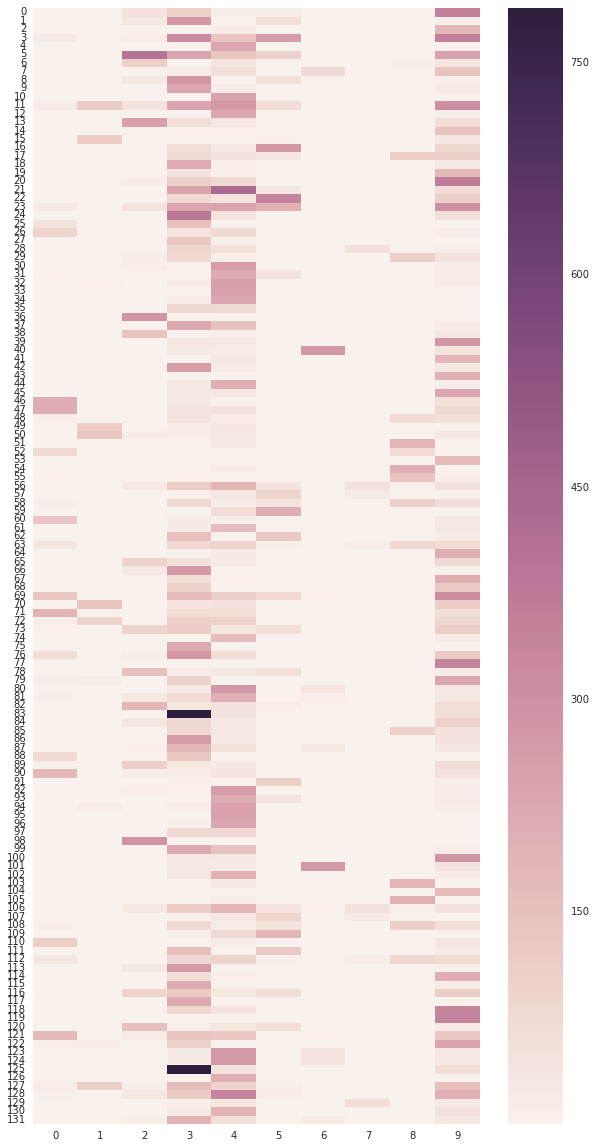

In [31]:
plt.figure(figsize=(10, 20))
sns.heatmap(df)

## WE COULD NOW MERGE IT WITH MORE INFO, E.G. WHO HELD THE SPEECH, AND THEN DO SOME ANALYSES. BUT MAYBE NO TIME FOR THAT? 

AANTEKENINGEN

MISSCHIEN GEWOON VERWIJZEN NAAR ONDERZOEK MET JOANNA EN NADIE?
https://github.com/damian0604/bdaca/blob/master/ipynb/timeseries.ipynb


# SCRATCH
different parameters. From docstring:
```
`alpha` and `eta` are hyperparameters that affect sparsity of the document-topic
(theta) and topic-word (lambda) distributions. Both default to a symmetric
1.0/num_topics prior.

`alpha` can be set to an explicit array = prior of your choice. It also
support special values of 'asymmetric' and 'auto': the former uses a fixed
normalized asymmetric 1.0/topicno prior, the latter learns an asymmetric
prior directly from your data.

`eta` can be a scalar for a symmetric prior over topic/word
distributions, or a matrix of shape num_topics x num_words, which can
be used to impose asymmetric priors over the word distribution on a
per-topic basis. This may be useful if you want to seed certain topics
with particular words by boosting the priors for those words.  It also
supports the special value 'auto', which learns an asymmetric prior
directly from your data.
```


In [ ]:
# example for different specification: repeat analysis 10 times, while learning alpha and eta from the data 
# instead of using 1/number of topics as defailt
mytfidflda = models.ldamodel.LdaModel(corpus=tfidfcorpus[ldacorpus],id2word=id2word,num_topics=50, alpha='auto', eta = 'auto',passes=10)


2017-07-08 17:09:07,758 : INFO : using autotuned alpha, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2017-07-08 17:09:07,762 : INFO : using autotuned eta, starting with [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02]
2017-07-08 17:09:07,765 : INFO : using serial LDA version on this node
2017-07-08 17:09:07,807 : INFO : running online LDA training, 50 topics, 10 passes over the supplied corpus of 132 documents, updating model once every 132 documents, evaluating perplexity 

In [41]:
vis_data = pyLDAvis.gensim.prepare(mytfidflda,ldacorpus,id2word)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.4/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.057058177686631e-05 and the largest is 0.0001590317051952846.
  RuntimeWarning
